In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error, accuracy_score

In [134]:
iris = load_iris()
x = iris['data']
x = preprocessing.normalize(x)
y = iris['target']
train_x, test_x, train_y, test_y = train_test_split(x, y)

In [151]:
est = KMeans(n_clusters=3)
est.fit(train_x)

import itertools
for order in list(itertools.permutations([0, 1, 2])):
    preds = np.choose(est.labels_, order).astype(np.int64)
    print(accuracy_score(preds, train_y))

0.9821428571428571
0.375
0.3392857142857143
0.0
0.017857142857142856
0.2857142857142857


In [11]:
preds = np.choose(est.labels_, [2, 1, 0]).astype(np.int64)

In [12]:
accuracy_score(preds, train_y)

0.0

## PSO Algorithm

In [13]:
def dist_func(z, x):
    return np.linalg.norm(z-x)

In [89]:
def initialize(data, nr_of_clusters):
  pop_size = 100

  # Initialize particles
  particles = []
  for n in range(pop_size):
      indexes = np.arange(data.shape[0])
      chosen_indexes = np.random.choice(indexes, nr_of_clusters, replace=False)
      particles.append(data[chosen_indexes])

  particles = np.array(particles)   
  local_best_particles = particles.copy()
  local_best_fitnesses = np.full(pop_size, np.inf)

  velocities = np.random.normal(0, 0.2, (pop_size, nr_of_clusters, data.shape[-1]))
  return particles, local_best_particles, local_best_fitnesses, velocities

In [111]:
def update_v(v, x, ind_opt, glob_opt, r1, r2):
    a1 = a2 = 1.49618
    w = 0.7298
    return [w*v[i] + a1*r1*(ind_opt[i] - x[i]) + a2*r2*(glob_opt[i] - x[i]) for i in range(len(x))]

def update_pos(x, new_v):
    return [x[i] + new_v[i] for i in range(len(x))]
  

In [124]:
def run_pso(data, nr_of_clusters):
  maxiter = 200
  global_best_fitness = np.inf
  particles, local_best_particles, local_best_fitnesses, velocities = initialize(data, nr_of_clusters)

  for i in range(maxiter):
      
      print('Progress: {}/{}'.format(i+1,maxiter))
      
      fitnesses = []
      for j, particle in enumerate(particles):
          clustering = []
          distances = np.zeros(nr_of_clusters)
          fitness = 0
          for z in data:
              # Calculate distance of data point z to each cluter centroid
              dists = [dist_func(z, centroid) for centroid in particle]
              # Assign to cluster
              cluster = dists.index(min(dists))
              clustering.append(cluster)
              # Summing distance of each datapoint assigned to cluster
              distances[cluster]+=min(dists)
              #fitness+= min(dists)
          # calculate fitness for this particle
          for cluster in range(nr_of_clusters):
              fitness += (distances[cluster] / clustering.count(cluster))
          fitness = fitness / nr_of_clusters
          fitnesses.append(fitness)
          
          # Update local best
          if fitness < local_best_fitnesses[j]:
              local_best_particles[j] = particle.copy()
              local_best_fitnesses[j] = fitness
      #print(f'particles: {particles}')
      print(f'fitnesses: {fitnesses}')

      # Update global best
      _new_best_fitness = np.min(fitnesses)
      if _new_best_fitness < global_best_fitness:
          global_best_fitness = _new_best_fitness
          global_best = particles[np.argmin(fitnesses)].copy()
      # print(fitnesses[0].shape)
      # print(_new_best_fitness.shape)

      print(f'best_fitnesses: {global_best_fitness}')
      
      # Update step
      r1 = np.random.uniform()
      r2 = np.random.uniform()
      for pidx in range(len(particles)):
          for cidx in range(len(particles[pidx])):
              velocities[pidx,cidx] = update_v(
                  velocities[pidx, cidx], 
                  particles[pidx, cidx], 
                  local_best_particles[pidx, cidx], 
                  global_best[cidx], r1, r2)
              particles[pidx][cidx] = update_pos(
                  particles[pidx][cidx], 
                  velocities[pidx,cidx])
                       
  return global_best, global_best_fitness

In [125]:
def get_labels(particle, x):
    labels = []
    for z in x:
        dists = [dist_func(z, centroid) for centroid in particle]
        labels.append(np.argmin(dists))
    return labels

In [126]:
import itertools
def calc_accuracy(pred_labels, test_labels):
  accuracy = 0
  for order in list(itertools.permutations([0, 1, 2])):
    preds = np.choose(test_pred_labels, order).astype(np.int64)
    new_accuracy = accuracy_score(preds, test_y)
    if new_accuracy > accuracy:
      accuracy = new_accuracy
  return accuracy

In [153]:
iris = load_iris()
x = iris['data']
x = preprocessing.normalize(x)
y = iris['target']
train_x, test_x, train_y, test_y = train_test_split(x, y)

global_best, quantization_error = run_pso(train_x, 3)
pred_labels = get_labels(global_best, train_x)
test_pred_labels =  get_labels(global_best, test_x)
accuracy = calc_accuracy(test_pred_labels, test_y)
print(accuracy)
print(quantization_error)

Progress: 1/200
fitnesses: [0.05264097443941515, 0.14681002494500886, 0.10098035521198784, 0.053655730762105634, 0.05295415094371223, 0.05839853179732398, 0.10278607303291683, 0.11525150492214985, 0.04794397898228364, 0.06390604669222164]
best_fitnesses: 0.04794397898228364
Progress: 2/200
fitnesses: [0.2420327659901509, 0.26948744621471976, nan, 0.3479322278633615, nan, nan, 0.14683841243894605, nan, 0.1960568718218917, 0.20022620670085858]
best_fitnesses: 0.04794397898228364
Progress: 3/200
fitnesses: [0.354846142697353, nan, nan, 0.4578958294461753, nan, nan, 0.24997298175363322, nan, 0.2659808031360647, nan]
best_fitnesses: 0.04794397898228364
Progress: 4/200
fitnesses: [nan, nan, nan, nan, nan, nan, 0.2592817880705549, nan, 0.24747365779960648, nan]
best_fitnesses: 0.04794397898228364
Progress: 5/200


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


fitnesses: [0.1784481923581858, nan, 0.15701026674052446, 0.13326879706537956, nan, 0.08514680284895614, 0.12289349053261274, 0.1441947726472567, 0.06594797723330754, 0.133231904217155]
best_fitnesses: 0.04794397898228364
Progress: 6/200
fitnesses: [nan, nan, nan, nan, 0.28511451170382457, 0.28354677184828997, 0.2375805048863515, nan, nan, nan]
best_fitnesses: 0.04794397898228364
Progress: 7/200
fitnesses: [nan, nan, 0.10810966280891898, 0.08285943492692077, 0.17254131148941468, 0.06135231390388287, 0.10226422925351537, 0.11511126546569349, 0.05315882104987193, nan]
best_fitnesses: 0.04794397898228364
Progress: 8/200
fitnesses: [0.2039023401165306, 0.22368797569192636, nan, 0.2604129443602417, 0.22807496957355852, nan, 0.1676099527146558, nan, 0.1606931818822077, 0.15094565007656716]
best_fitnesses: 0.04794397898228364
Progress: 9/200
fitnesses: [0.10250289056373851, 0.09097402164045644, 0.1052011421425773, 0.09659096483923342, 0.09481898494007802, 0.08082271085362464, 0.12060805052752

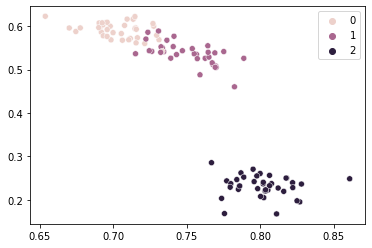

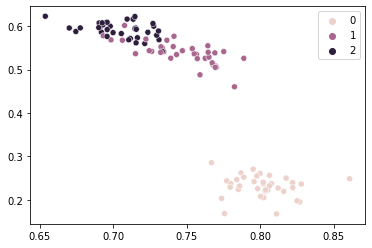

In [154]:
import seaborn as sb

sb.scatterplot(x=train_x[:,0], y=train_x[:,2], hue=pred_labels)
plt.show()
sb.scatterplot(x=train_x[:,0], y=train_x[:,2], hue=train_y)
plt.show()

In [155]:
print(get_quantization_error(train_x, global_best))
print(get_quantization_error(train_x, est.cluster_centers_))

0.04253133879274676
0.041377152580612094


In [138]:
iris = load_iris()
x = iris['data']
y = iris['target']
train_x, test_x, train_y, test_y = train_test_split(x, y)

global_best, quantization_error = run_pso(train_x, 3)
pred_labels = get_labels(global_best, train_x)
test_pred_labels =  get_labels(global_best, test_x)
accuracy = calc_accuracy(test_pred_labels, test_y)
print(accuracy)
print(quantization_error)

Progress: 1/200
fitnesses: [0.84266134036965, 1.3705903280618585, 1.8872809045542682, 0.9397253054158726, 0.9163674829208208, 1.8731514390842736, 0.8133949359715266, 0.906104584466484, 1.1663781176894557, 0.9608070666495615]
best_fitnesses: 0.8133949359715266
Progress: 2/200
fitnesses: [0.998724787831863, 1.0108156387217972, 0.9833936843623693, 1.0297003826096802, 0.8988930640373057, 0.9709626673930738, 0.8279800579466046, 0.9101619822839385, 0.9021300712325323, 0.8837431406995898]
best_fitnesses: 0.8133949359715266
Progress: 3/200
fitnesses: [2.9660934990637826, nan, nan, nan, nan, nan, 0.8295302976647597, nan, 1.9808909629544988, 2.9490163758583363]
best_fitnesses: 0.8133949359715266
Progress: 4/200
fitnesses: [0.8363188717060491, 1.1004733929310775, 1.0690157742101032, 0.8083581621374135, 1.1041845475026133, 0.9881426064207929, 0.8296468730609338, 0.9147360867775886, 0.9142600399819285, 1.0258710619314748]
best_fitnesses: 0.8083581621374135
Progress: 5/200
fitnesses: [1.094562641944

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


fitnesses: [0.8672664072232728, 0.8734060441408729, 0.9857166130211344, 0.8760595037702891, 0.9466942002201056, 0.9132258376405851, 0.8090542995006965, 0.9762239291362382, 0.9788189639486035, 1.0123239333320084]
best_fitnesses: 0.8083581621374135
Progress: 7/200
fitnesses: [1.8874963641489932, 0.9895160837830442, 1.6177113557082834, 1.9123469109117703, nan, 0.8497541258723054, 0.8617947783303759, 2.4517444765552106, 1.3240667557515091, 1.7357684436741423]
best_fitnesses: 0.8083581621374135
Progress: 8/200
fitnesses: [1.1620487877816483, 0.9289840888575746, 0.8467496453506044, 1.1035913556725772, 0.837988883740536, 0.8883687450676568, 0.8020262404086322, 0.9945689531812268, 0.8716262474332511, 0.8738146476149149]
best_fitnesses: 0.8020262404086322
Progress: 9/200
fitnesses: [1.143949768820516, 0.9245871282017678, 1.0938307867546602, 1.1430797964432806, 1.3585261857246567, 0.8105296456271439, 0.8603753521235173, 0.9802242160568619, 1.2721003499144057, 1.338732100146528]
best_fitnesses: 0

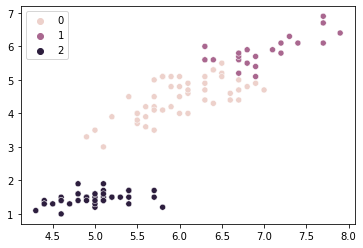

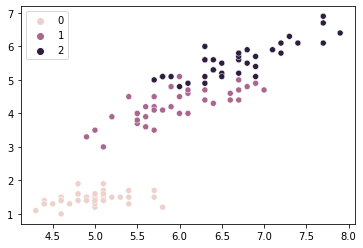

In [139]:
import seaborn as sb

sb.scatterplot(x=train_x[:,0], y=train_x[:,2], hue=pred_labels)
plt.show()
sb.scatterplot(x=train_x[:,0], y=train_x[:,2], hue=train_y)
plt.show()

In [140]:
def generate_problem_data():
  x = np.random.uniform(-1, 1, size=(400, 2))
  y = [1 if item[0] >= 0.7 or (item[0] <= 0.3 and item[1] >= -0.2 - item[0]) else 0 for item in x]
  return x, y




In [141]:
x, y = generate_problem_data()
train_x, test_x, train_y, test_y = train_test_split(x, y)

global_best, quantization_error = run_pso(train_x, 2)
pred_labels = get_labels(global_best, train_x)
test_pred_labels =  get_labels(global_best, test_x)
accuracy = calc_accuracy(test_pred_labels, test_y)
print(accuracy)
print(quantization_error)

Progress: 1/200
fitnesses: [0.5843018982249559, 1.0169748449537723, 0.6298689660556229, 0.77998031578447, 0.6047532343758276, 0.7321991685552776, 0.7619599738429005, 0.6030091437134811, 0.9182391855166434, 0.7791640036190635]
best_fitnesses: 0.5843018982249559
Progress: 2/200
fitnesses: [0.6041438186368832, 0.6641915849140618, 0.6558408300206675, 0.6682887170477122, 0.684132354090933, 0.7012420068179961, 0.6665345055466924, 0.5657059910713974, 0.6895012026595241, 0.6723102694889149]
best_fitnesses: 0.5657059910713974
Progress: 3/200
fitnesses: [0.6524573513477168, 0.581335115919332, 0.823827002493795, 0.6989968001352446, 0.562002849043714, 0.540196559344444, 0.553267307376557, 0.5634889188429538, 0.5706699585755092, 0.5524494207192157]
best_fitnesses: 0.540196559344444
Progress: 4/200
fitnesses: [0.6415672978072355, 0.7280798498867553, 0.8246557655483251, 0.5776744185147744, 0.636493825858659, 0.5943224414275763, 0.6519183047829336, 0.5485739215675236, 0.6140001756863827, 0.65438269491

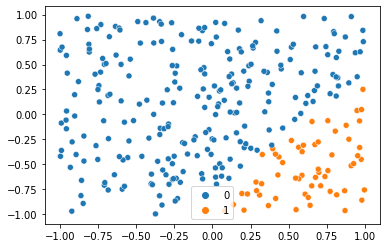

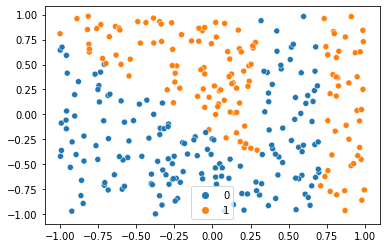

In [144]:
sb.scatterplot(x=train_x[:,0], y=train_x[:,1], hue=pred_labels)
plt.show()
sb.scatterplot(x=train_x[:,0], y=train_x[:,1], hue=train_y)
plt.show()

In [145]:
est = KMeans(n_clusters=2)
est.fit(train_x)

import itertools
for order in list(itertools.permutations([0, 1, 2])):
    preds = np.choose(est.labels_, order).astype(np.int64)
    print(accuracy_score(preds, train_y))

0.7366666666666667
0.4
0.2633333333333333
0.11666666666666667
0.14666666666666667
0.33666666666666667


In [146]:
def get_quantization_error(data, particle):
  clustering = []
  nr_of_clusters = len(particle)
  distances = np.zeros(nr_of_clusters)
  fitness = 0
  for z in data:
      # Calculate distance of data point z to each cluter centroid
      dists = [dist_func(z, centroid) for centroid in particle]
      # Assign to cluster
      cluster = dists.index(min(dists))
      clustering.append(cluster)
      # Summing distance of each datapoint assigned to cluster
      distances[cluster]+=min(dists)
      #fitness+= min(dists)
  # calculate fitness for this particle
  for cluster in range(nr_of_clusters):
      fitness += (distances[cluster] / clustering.count(cluster))
  fitness = fitness / nr_of_clusters
  return fitness

In [149]:
print(get_quantization_error(train_x, global_best))
print(get_quantization_error(train_x, est.cluster_centers_))

0.5348280016221247
0.5711234721553284


From these results, we conclude:
- we normalized our data to compare it to a succesful k-means clustering, as kmeans needs normalized data
- to compare it to the paper data, we made a none normalized fit. Our quantization error is slightly better than the error reported in the paper.
- we observe that sometimes PSO finds clusters that differ from the original clusters, while still achieving a good fitness score. We believe this is because the quantization error is less sensitive to the cluster size than kmeans with summed errors.
- kmeans is better on iris (normalized)
- PSO is better on the artificial problem
- but since there cannot be a good solution to the artificial problem, quantization error is less informative